In [32]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr
import seaborn as sns
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/sam_summer.yaml'

In [34]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)
st = storm_tracker.StormTracker(gr, overwrite = False) #overwrite = True is super long
# jd = joint_distrib.JointDistribution(gr, st)

Data loaded from /scratchx/mcarenso/tempest/SAM_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/SAM_lowRes_Tropics/grid_attributes.pkl instead of computing
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 3.98 seconds


In [35]:
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nd=5, overwrite = True, dist_mask = False)
# jd_mm = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_Prec", var_id_2 = "max_Prec", nd=5, overwrite = True)

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 12.79 seconds


In [6]:
jd.prec["strat_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_50_Prec * jd.prec.cond_alpha_50_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_50_Prec)
jd.prec["strat_conv_ratio_Prec"] = jd.prec.cond_alpha_50_Prec / jd.prec.strat_Prec

## Get land and ocean masks

In [4]:
lm = gr.get_landmask()
land = lm.Landmask == 1
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

In [5]:
lm.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:     (lat_global: 60, lon_global: 360)
Coordinates:
  * lat_global  (lat_global) float64 -29.5 -28.5 -27.5 -26.5 ... 27.5 28.5 29.5
  * lon_global  (lon_global) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    Landmask    (lat_global, lon_global) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0>

# Figure 1 
Show distribs TODO make it land and ocean with ocean on top and land on bottom


In [26]:
# convective_mask = xr.where(jd.prec.Treshold_cond_alpha_50_Prec > 2, True, False)
# convective_mask = True

convective_mask = xr.where(jd.prec.mean_unweighted_Prec >0.25 , True, False)

jd.prec["strat_50_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_50_Prec * jd.prec.cond_alpha_50_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_50_Prec)
jd.prec["strat_conv_50_ratio_Prec"] = jd.prec.cond_alpha_50_Prec / jd.prec.strat_Prec

P = jd.prec.mean_unweighted_Prec.where(convective_mask).values.ravel()
p_50 = jd.prec.threshold_cond_alpha_50_Prec.where(convective_mask).values.ravel()
P_50 = jd.prec.cond_alpha_50_Prec.where(convective_mask).values.ravel()
s_50 = jd.prec.Sigma_cond_alpha_50_Prec.where(convective_mask).values.ravel()
Ps_50 = jd.prec.strat_Prec.where(convective_mask).values.ravel()
Ratio_50 = jd.prec.strat_conv_ratio_Prec.where(convective_mask).values.ravel()
Land_Ocean = lm.Landmask.where(convective_mask).values.ravel()
Topography = np.where(Land_Ocean == 1, "Land", "Ocean")

In [20]:
# convective_mask = xr.where(jd.prec.threshold_cond_alpha_50_Prec > 2, True, False)
# mask = ocean & convective_mask
# P = jd.prec.mean_unweighted_Prec.where(mask).values.ravel()
# p_50 = jd.prec.threshold_cond_alpha_50_Prec.where(mask).values.ravel()
# P_50 = jd.prec.cond_alpha_50_Prec.where(mask).values.ravel()
# s_50 = jd.prec.Sigma_cond_alpha_50_Prec.where(mask).values.ravel()

In [21]:
# convective_mask = xr.where(jd.prec.threshold_cond_alpha_50_Prec > 2, True, False)
# mask = land & convective_mask
# P_land = jd.prec.mean_unweighted_Prec.where(mask).values.ravel()
# p_50_land = jd.prec.threshold_cond_alpha_50_Prec.where(mask).values.ravel()
# P_50_land = jd.prec.cond_alpha_50_Prec.where(mask).values.ravel()
# s_50_land = jd.prec.Sigma_cond_alpha_50_Prec.where(mask).values.ravel()

In [24]:
# %matplotlib inline

# # data = {'$P$': [P, P_land], '$P_{0.5}$': [P_50, P_50_land], '$p_{0.5}$': [p_50, p_50_land], '$\sigma_{0.5}$': [s_50, s_50_land]}
# data = {'$P$': [P], '$P_{0.5}$': [P_50], '$\sigma_{0.5}$': [s_50], '$p_{0.5}$': [p_50], '$P_{1-0.5}$' : [Ps_50], '$P_{0.5}/P_{1-0.5}$' : [Ratio_50]}

# plt.rcParams['text.usetex'] = True

# # Set up the plot
# fig, axs = plt.subplots(1, 6, figsize=(13.5, 4))
# y_labels = ["$mm/h$", "$mm/h$", "", "$mm/h$", "$mm/h$", ""]
# # Violin Plot
# for key, ax, y_label in zip(data.keys(), axs.flatten(), y_labels):
#     # sns.violinplot(data=np.log1p(data[key]), inner="quartile", palette="pastel", ax = ax)
#     sns.violinplot(data=data[key][0], inner="quart", color="lightblue", width=0.9, ax = ax, orient='v')
#     # sns.violinplot(data=data[key][1], inner="quartile", palette="inferno", width=0.9, ax = ax, alpha = 0.5)

#     ax.set_title(key)
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position('right')
#     ax.set_ylabel(y_label)
#     ax.set_xticks([])
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("Precip_features.png")

/scratchx/mcarenso/ipykernel_2588690/3818178201.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 1
/scratchx/mcarenso/ipykernel_2588690/3818178201.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 1


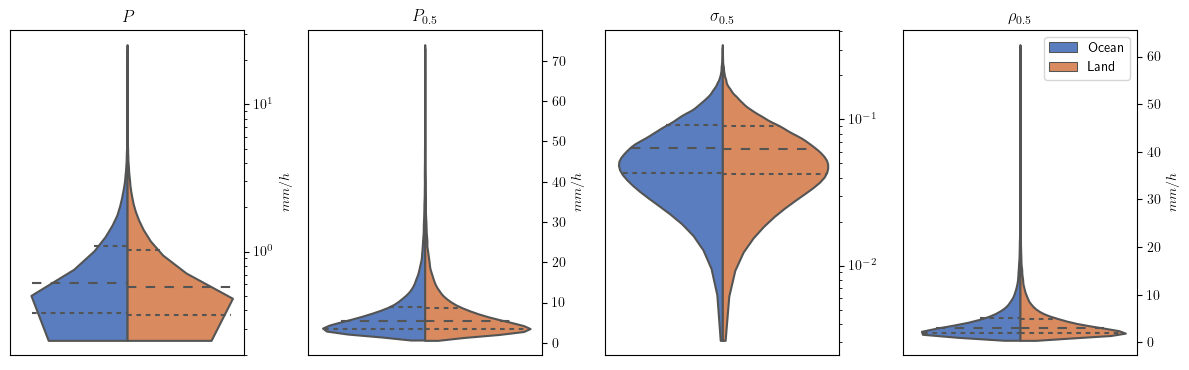

In [26]:
%matplotlib inline
# sns.set(style="whitegrid")

fake_x = np.zeros_like(P[~np.isnan(P)])

# data = {'$P$': [P, P_land], '$P_{0.5}$': [P_50, P_50_land], '$p_{0.5}$': [p_50, p_50_land], '$\sigma_{0.5}$': [s_50, s_50_land]}
data = {r'$P$': P[~np.isnan(P)], r'$P_{0.5}$':P_50[~np.isnan(P_50)], r'$\sigma_{0.5}$': s_50[~np.isnan(s_50)], r'$\rho_{0.5}$': p_50[~np.isnan(p_50)],'x' : fake_x,  'Land_Ocean' : Topography[~np.isnan(P)]} #, '$P_{1-0.5}$' : [Ps_50], '$P_{0.5}/P_{1-0.5}$' : [Ratio_50]

plt.rcParams['text.usetex'] = True

# Set up the plot
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
y_labels = ["$mm/h$", "$mm/h$", "", "$mm/h$", "$mm/h$", ""]
# Violin Plot
for key, ax, y_label in zip(data.keys(), axs.flatten(), y_labels):
    # sns.violinplot(data=np.log1p(data[key]), inner="quartile", palette="pastel", ax = ax)
    sns.violinplot(data=data, x='x' ,y = key, hue = 'Land_Ocean', inner="quart", width=0.9, palette="muted", gap=0.1, split = True,  ax = ax, orient='v', cut=0) #  
    # sns.violinplot(data=data[key][1], inner="quartile", palette="inferno", width=0.9, ax = ax, alpha = 0.5)

    ax.set_title(key)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.set_ylabel(y_label)
    ax.set_xticks([])
    if key == '$P$' or key == '$\sigma_{0.5}$' : 
        ax.set_yscale('log')  # Set the y-axis to logarithmic scale
        ax.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 1
    if key != r'$\rho_{0.5}$':
        ax.get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])

# fig.suptitle(r'Precipitation features retrieved for $\alpha$ set to $0.5$', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Precip_features.png")

In [13]:
# jd.prec["strat_10_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_10_Prec * jd.prec.cond_alpha_10_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_10_Prec)
# jd.prec["strat_conv_10_ratio_Prec"] = jd.prec.cond_alpha_10_Prec / jd.prec.strat_Prec


# P = jd.prec.mean_unweighted_Prec.where(convective_mask).values.ravel()
# p_10 = jd.prec.Treshold_cond_alpha_10_Prec.where(convective_mask).values.ravel()
# P_10 = jd.prec.cond_alpha_10_Prec.where(convective_mask).values.ravel()
# s_10 = jd.prec.Sigma_cond_alpha_10_Prec.where(convective_mask).values.ravel()
# Ps_10 = jd.prec.strat_Prec.where(convective_mask).values.ravel()
# Ratio_10 = jd.prec.strat_conv_ratio_Prec.where(convective_mask).values.ravel()

In [14]:
# %matplotlib inline

# jd.prec["strat_10_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_10_Prec * jd.prec.cond_alpha_10_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_10_Prec)
# jd.prec["strat_conv_10_ratio_Prec"] = jd.prec.cond_alpha_10_Prec / jd.prec.strat_Prec


# P = jd.prec.mean_unweighted_Prec.where(convective_mask).values.ravel()
# p_10 = jd.prec.Treshold_cond_alpha_10_Prec.where(convective_mask).values.ravel()
# P_10 = jd.prec.cond_alpha_10_Prec.where(convective_mask).values.ravel()
# s_10 = jd.prec.Sigma_cond_alpha_10_Prec.where(convective_mask).values.ravel()
# Ps_10 = jd.prec.strat_Prec.where(convective_mask).values.ravel()
# Ratio_10 = jd.prec.strat_conv_ratio_Prec.where(convective_mask).values.ravel()

# # data = {'$P$': [P, P_land], '$P_{0.1}$': [P_10, P_10_land], '$p_{0.1}$': [p_10, p_10_land], '$\sigma_{0.1}$': [s_10, s_10_land]}
# data = {'$P$': [P], '$P_{0.1}$': [P_10], '$\sigma_{0.1}$': [s_10], '$p_{0.1}$': [p_10], '$P_{1-0.1}$' : [Ps_10], '$P_{0.1}/P_{1-0.1}$' : [Ratio_10]}

# plt.rcParams['text.usetex'] = True

# # Set up the plot
# fig, axs = plt.subplots(1, 6, figsize=(13.5, 4))
# y_labels = ["$mm/h$", "$mm/h$", "", "$mm/h$", "$mm/h$", ""]
# # Violin Plot
# for key, ax, y_label in zip(data.keys(), axs.flatten(), y_labels):
#     # sns.violinplot(data=np.log1p(data[key]), inner="quartile", palette="pastel", ax = ax)
#     sns.violinplot(data=data[key][0], inner="quart", color="lightblue", width=0.9, ax = ax, orient='v')
#     # sns.violinplot(data=data[key][1], inner="quartile", palette="inferno", width=0.9, ax = ax, alpha = 0.1)

#     ax.set_title(key)
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position('right')
#     ax.set_ylabel(y_label)
#     ax.set_xticks([])
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("Precip_features.png")

In [15]:
# %matplotlib inline

# jd.prec["strat_90_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_90_Prec * jd.prec.cond_alpha_90_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_90_Prec)
# jd.prec["strat_conv_90_ratio_Prec"] = jd.prec.cond_alpha_90_Prec / jd.prec.strat_Prec


# P = jd.prec.mean_unweighted_Prec.where(convective_mask).values.ravel()
# p_90 = jd.prec.Treshold_cond_alpha_90_Prec.where(convective_mask).values.ravel()
# P_90 = jd.prec.cond_alpha_90_Prec.where(convective_mask).values.ravel()
# s_90 = jd.prec.Sigma_cond_alpha_90_Prec.where(convective_mask).values.ravel()
# Ps_90 = jd.prec.strat_Prec.where(convective_mask).values.ravel()
# Ratio_90 = jd.prec.strat_conv_ratio_Prec.where(convective_mask).values.ravel()

# # data = {'$P$': [P, P_land], '$P_{0.9}$': [P_90, P_90_land], '$p_{0.9}$': [p_90, p_90_land], '$\sigma_{0.9}$': [s_90, s_90_land]}
# data = {'$P$': [P], '$P_{0.9}$': [P_90], '$\sigma_{0.9}$': [s_90], '$p_{0.9}$': [p_90], '$P_{1-0.9}$' : [Ps_90], '$P_{0.9}/P_{1-0.9}$' : [Ratio_90]}

# plt.rcParams['text.usetex'] = True

# # Set up the plot
# fig, axs = plt.subplots(1, 6, figsize=(13.5, 4))
# y_labels = ["$mm/h$", "$mm/h$", "", "$mm/h$", "$mm/h$", ""]
# # Violin Plot
# for key, ax, y_label in zip(data.keys(), axs.flatten(), y_labels):
#     # sns.violinplot(data=np.log1p(data[key]), inner="quartile", palette="pastel", ax = ax)
#     sns.violinplot(data=data[key][0], inner="quart", color="lightblue", width=0.9, ax = ax, orient='v')
#     # sns.violinplot(data=data[key][1], inner="quartile", palette="inferno", width=0.9, ax = ax, alpha = 0.9)

#     ax.set_title(key)
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position('right')
#     ax.set_ylabel(y_label)
#     ax.set_xticks([])
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("Precip_features.png")

In [16]:
# %matplotlib inline

# jd.prec["strat_01_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_01_Prec * jd.prec.cond_alpha_01_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_01_Prec)
# jd.prec["strat_conv_01_ratio_Prec"] = jd.prec.cond_alpha_01_Prec / jd.prec.strat_Prec


# P = jd.prec.mean_unweighted_Prec.where(convective_mask).values.ravel()
# p_01 = jd.prec.Treshold_cond_alpha_01_Prec.where(convective_mask).values.ravel()
# P_01 = jd.prec.cond_alpha_01_Prec.where(convective_mask).values.ravel()
# s_01 = jd.prec.Sigma_cond_alpha_01_Prec.where(convective_mask).values.ravel()
# Ps_01 = jd.prec.strat_01_Prec.where(convective_mask).values.ravel()
# Ratio_01 = jd.prec.strat_conv_01_ratio_Prec.where(convective_mask).values.ravel()

# # data = {'$P$': [P, P_land], '$P_{0.01}$': [P_01, P_01_land], '$p_{0.01}$': [p_01, p_01_land], '$\sigma_{0.01}$': [s_01, s_01_land]}
# data = {'$P$': [P], '$P_{0.01}$': [P_01], '$\sigma_{0.01}$': [s_01], '$p_{0.01}$': [p_01], '$P_{1-0.01}$' : [Ps_01], '$P_{0.01}/P_{1-0.01}$' : [Ratio_01]}

# plt.rcParams['text.usetex'] = True

# # Set up the plot
# fig, axs = plt.subplots(1, 6, figsize=(13.5, 4))
# y_labels = ["$mm/h$", "$mm/h$", "", "$mm/h$", "$mm/h$", ""]
# # Violin Plot
# for key, ax, y_label in zip(data.keys(), axs.flatten(), y_labels):
#     # sns.violinplot(data=np.log1p(data[key]), inner="quartile", palette="pastel", ax = ax)
#     sns.violinplot(data=data[key][0], inner="quart", color="lightblue", width=0.9, ax = ax, orient='v')
#     # sns.violinplot(data=data[key][1], inner="quartile", palette="inferno", width=0.01, ax = ax, alpha = 0.01)

#     ax.set_title(key)
#     ax.yaxis.tick_right()
#     ax.yaxis.set_label_position('right')
#     ax.set_ylabel(y_label)
#     ax.set_xticks([])
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("Precip_features.png")

# Figure 2 
### Mutual information

In [36]:
import math 

def mutual_information(self, threshold=10):
    mi_pos = 0
    mi_neg = 0
    l1, l2 = len(self.bins1)-1, len(self.bins2)-1
    bin_widths1=np.diff(self.dist1.bins)
    bin_widths2=np.diff(self.dist2.bins)
    bin_areas = np.outer(bin_widths1,bin_widths2)
    for i in range(threshold, l1):
        for j in range(threshold, l2):
            if self.norm_density[i,j] != 0 : 
                
                mi_ij = self.density[i,j]*math.log10(self.norm_density[i,j])*bin_areas[i,j]
                if mi_ij >0:
                    mi_pos+=mi_ij
                else:
                    mi_neg+=mi_ij
                    
            else : 
                pass
                
    return mi_pos+mi_neg, mi_pos, mi_neg

In [37]:
gr.get_var_id_ds("Prec")

<xarray.Dataset>
Dimensions:                             (lat_global: 60, lon_global: 360,
                                         days: 40, time: 48)
Coordinates:
  * lat_global                          (lat_global) float64 -29.5 ... 29.5
  * lon_global                          (lon_global) float64 0.5 1.5 ... 359.5
  * days                                (days) object '16-08-01' ... '16-09-09'
  * time                                (time) int64 0 1 2 3 4 ... 44 45 46 47
Data variables: (12/48)
    global_pixel_surf                   (lat_global, lon_global, days) float64 ...
    max_Prec                            (lat_global, lon_global, days) float64 ...
    mean_Prec                           (lat_global, lon_global, days) float64 ...
    cond_alpha_85_Prec                  (lat_global, lon_global, days) float64 ...
    mean_unweighted_Prec                (lat_global, lon_global, days) float64 ...
    Sigma_cond_alpha_85_Prec            (lat_global, lon_global, days) float64 ...
    ...                                  ...
    threshold_cond_alpha_90_Prec        (lat_global, lon_global, days) float64 ...
    Sigma_intra_day_cond_alpha_90_Prec  (lat_global, lon_global, time, days) float64 ...
    cond_alpha_99_Prec                  (lat_global, lon_global, days) float64 ...
    Sigma_cond_alpha_99_Prec            (lat_global, lon_global, days) float64 ...
    threshold_cond_alpha_99_Prec        (lat_global, lon_global, days) float64 ...
    Sigma_intra_day_cond_alpha_99_Prec  (lat_global, lon_global, time, days) float64 ...

In [38]:
def make_jds(var_id):
    jd_xy = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = var_id, nd=5, overwrite = True, dist_mask = False)
    jd_100 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_00_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_99 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_01_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_90 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_10_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_80 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_20_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_75 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_25_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_50 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_25 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_75_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_20 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_80_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_15 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_85_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_10 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_90_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_01 = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "cond_alpha_99_Prec", nd=5, overwrite = True, dist_mask = False)
    jd_max = joint_distrib.JointDistribution(gr, st, var_id_1 = var_id, var_id_2 = "max_Prec", nd=5, overwrite = True, dist_mask = False)
    jds = [jd_max, jd_01, jd_10, jd_15, jd_20, jd_25, jd_50, jd_75,jd_80, jd_90, jd_99, jd_100, jd_xy]
    return jds

jds = make_jds("mean_unweighted_Prec")

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 11.40 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 11.87 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 12.05 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 12.06 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 12.05 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and savin

In [21]:
jds_conv_10 = make_jds("convective_10_Prec") #convective_Prec

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 4.50 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.97 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.99 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.84 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.78 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.33 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.71 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.68 seconds


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.67 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.79 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.74 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.76 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.15 seconds


In [21]:
# jds_conv_15 = make_jds("convective_15_Prec")

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 2.09 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 2.60 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 2.60 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 2.72 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 2.66 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving the

In [23]:
jds_conv_30 = make_jds("convective_30_Prec")

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 3.87 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.09 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.10 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.11 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.04 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 5.11 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 4.94 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 4.86 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 4.87 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 4.87 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 4.78 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 4.53 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 4.54 seconds


In [25]:
jds_conv_03 = make_jds("convective_03_Prec")

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.55 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.85 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.75 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.36 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.29 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.26 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.43 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.66 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.56 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.72 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.77 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.81 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1064: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 6.78 seconds


## Test convective joint distribs

In [39]:
def make_mis(jds):
    mi, mi_pos, mi_neg = [], [], []
    for jd in jds : 
        jd.compute_joint_density(jd.sample1, jd.sample2, method = 'default')
        out = mutual_information(jd, 0)
        mi.append(out[0])
        mi_pos.append(out[1])
        mi_neg.append(out[2])
        
    return mi

mi = make_mis(jds)
# mi_conv_03 = make_mis(jds_conv_03)
# mi_conv_10 = make_mis(jds_conv_10)
# # mi_conv_15 = make_mis(jds_conv_15)
# mi_conv_30 = make_mis(jds_conv_30)
# mis = [mi, mi_conv_03, mi_conv_10, mi_conv_30] #, mi_conv_15
mis= [mi]

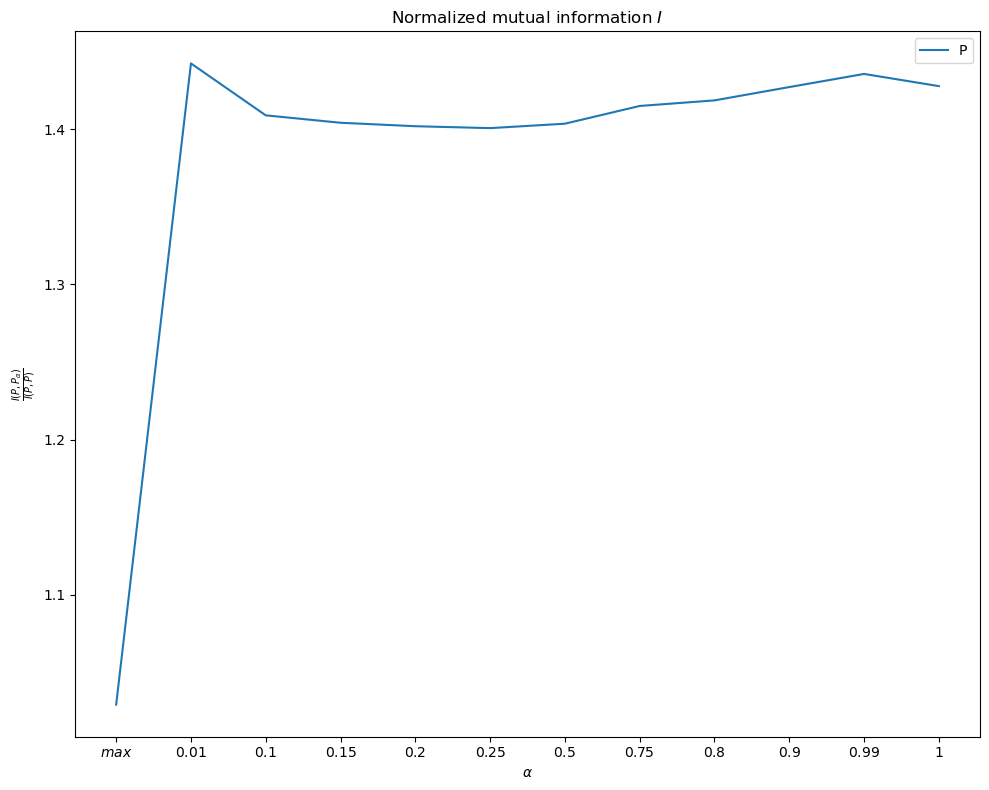

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

conv = False
alphas = [f"${i}$" for i in ["max", 0.01, 0.1, 0.15, 0.2, 0.25, 0.50, 0.75, 0.8, 0.9, 0.99, 1]] # , "Identity", 

fig, ax = plt.subplots(1, 1, figsize=(10,8))
for mi,label in zip(mis, ["P", "Pp03", "Pp10", "Pp30"]): #Pp08, , "Pp15"
    ax.plot(alphas, mi[:-1], label = label) #/mi[-1]
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\frac{I(P, P_{\alpha})}{I(P, P)}$')
# ax.set_ylim(bottom=0, top=1)  # Set y-axis to range from 0 to 1
    
ax.set_title(r'Normalized mutual information $I$')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# %matplotlib inline
# jd =joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_01_Prec", nd=5, overwrite = True, dist_mask = False)

# fig, axs = plt.subplots(1, 3, figsize=(3.75*4.8, 4.85))

# jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
# axs[0].set_title("Les légendes sont à refaire")
# jd.plot(mask = False, branch=False, fig = fig, ax = axs[1])
# jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
# plt.tight_layout()

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 3.60 seconds


/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


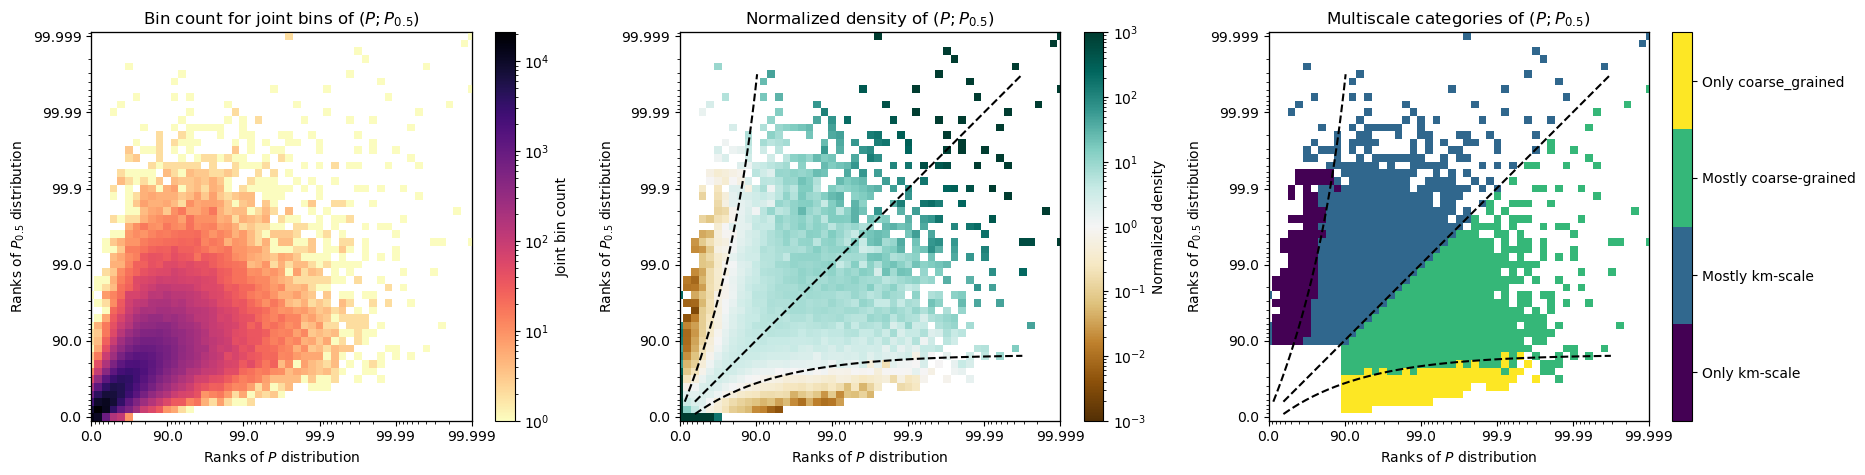

IOStream.flush timed out


In [6]:
%matplotlib inline
import matplotlib as mpl

jd =joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nd=5, overwrite = True, dist_mask = True)

fig, axs = plt.subplots(1, 3, figsize=(3.92*4.8, 4.85))

ax, cb = jd.plot_data(jd.bincount, scale = 'log', label = "Joint bin count", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
ax.set_title(r"Bin count for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.5}$ distribution")

ax, cb = jd.plot(mask = False, branch=True, fig = fig, ax = axs[1])
ax.set_title(r"Normalized density of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.5}$ distribution")

ax, cb = jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
cb.remove()

ax.set_title(r"Multiscale categories of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.5}$ distribution")

values = np.unique([1, 2, 3, 4])
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0.5, 5), cmap.N)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    ax=ax, ticks=values, spacing='proportional')
cbar.set_ticklabels(['Only km-scale', 'Mostly km-scale', 'Mostly coarse-grained', 'Only coarse_grained'])

fig.tight_layout()
plt.savefig("norm_density.png")

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.06 seconds


/home/mcarenso/code/tempest/tempest/joint_distrib.py:718: RuntimeWarning: invalid value encountered in scalar divide
  bin_fraction_mcs[i_bin,j_bin] = count_bin_mcs/count_bin


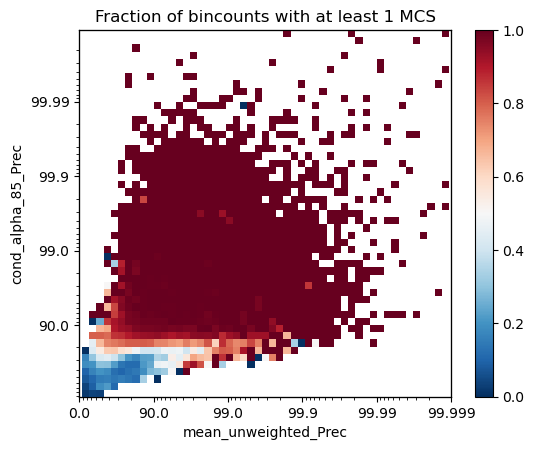

In [19]:
jd =joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nd=5, overwrite = True, dist_mask = False)
data, noise, count = jd.get_mcs_bin_fraction(0)
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.76))
jd.plot_data(data, noise, branch=False, fig= fig, ax = ax, vbds = (0, 1))
ax.set_title("Fraction of bincounts with at least 1 MCS")
plt.savefig("MCS_cov.png")

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.23 seconds


/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


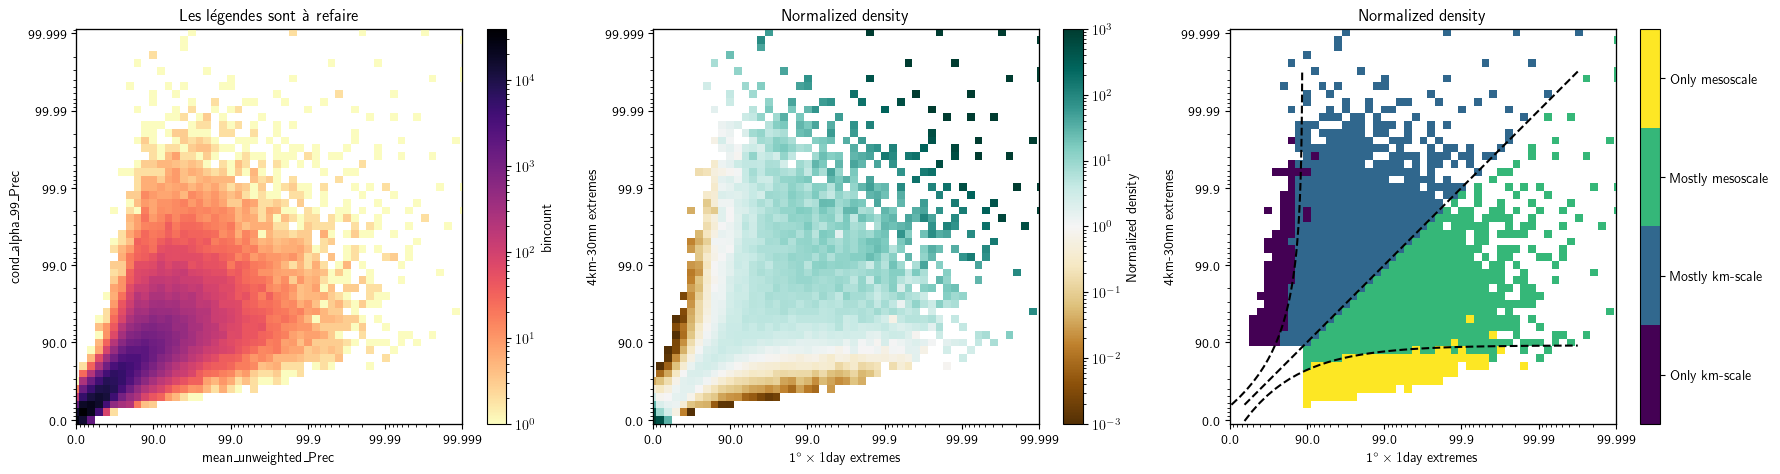

In [22]:
%matplotlib inline
jd =joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_99_Prec", nd=5, overwrite = True, dist_mask = False)

fig, axs = plt.subplots(1, 3, figsize=(3.75*4.8, 4.85))

jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
axs[0].set_title("Les légendes sont à refaire")
jd.plot(mask = False, branch=False, fig = fig, ax = axs[1])
jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
plt.tight_layout()

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.25 seconds


/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/mcarenso/code/tempest/tempest/joint_distrib.py:436: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


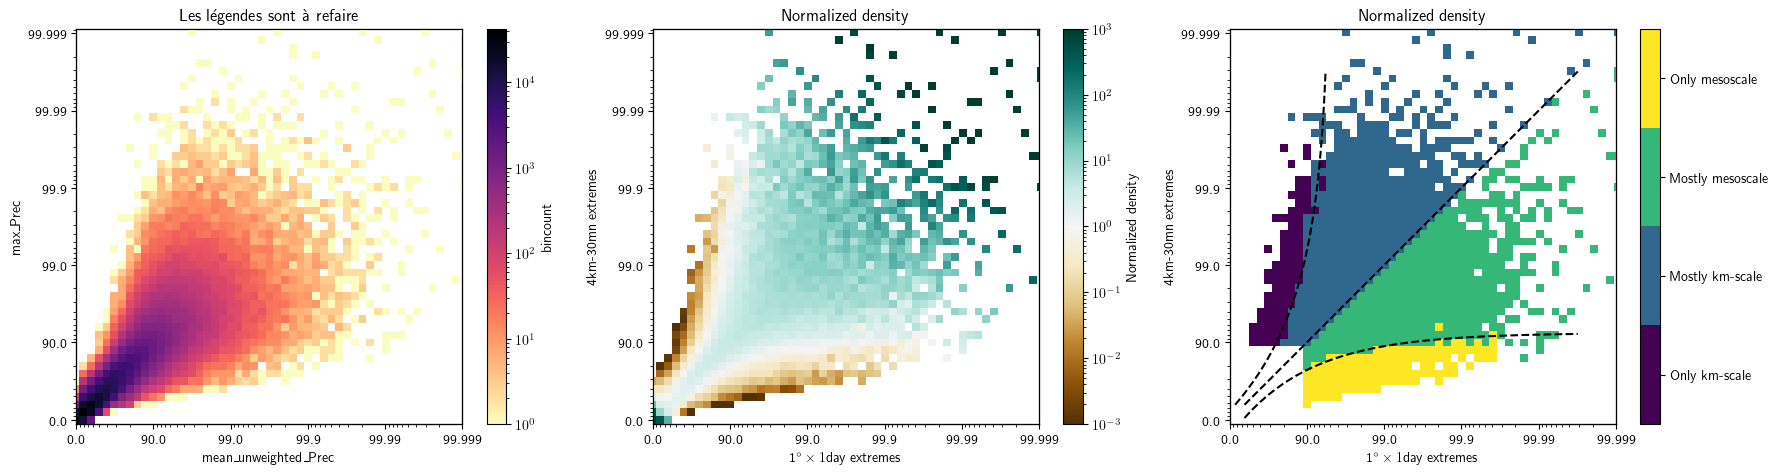

In [23]:
%matplotlib inline
jd =joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "max_Prec", nd=5, overwrite = True, dist_mask = False)

fig, axs = plt.subplots(1, 3, figsize=(3.75*4.8, 4.85))

jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
axs[0].set_title("Les légendes sont à refaire")
jd.plot(mask = False, branch=False, fig = fig, ax = axs[1])
jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
plt.tight_layout()

In [ ]:
# from scipy.stats import spearmanr
# # Assuming p_75 and s_75 are your data arrays
# print(spearmanr(p_75[~np.isnan(p_75)], s_75[~np.isnan(s_75)]))
# print(spearmanr(P_75[~np.isnan(P_75)], s_75[~np.isnan(s_75)]))
# print(spearmanr(P_75[~np.isnan(P_75)], P[~np.isnan(P)]))

# # triple corr coeff
# np.corrcoef([P[~np.isnan(P)],  P_75[~np.isnan(P_75)],  s_75[~np.isnan(s_75)], p_75[~np.isnan(p_75)], Ps_75[~np.isnan(Ps_75)], Ratio_75[~np.isnan(Ratio_75)]])

In [ ]:
# from scipy.stats import spearmanr
# # Assuming p_90 and s_90 are your data arrays
# print(spearmanr(p_90[~np.isnan(p_90)], s_90[~np.isnan(s_90)]))
# print(spearmanr(P_90[~np.isnan(P_90)], s_90[~np.isnan(s_90)]))
# print(spearmanr(P_90[~np.isnan(P_90)], P[~np.isnan(P)]))

# # triple corr coeff
# np.corrcoef([P[~np.isnan(P)],  P_90[~np.isnan(P_90)],  s_90[~np.isnan(s_90)], p_90[~np.isnan(p_90)], Ps_90[~np.isnan(Ps_90)], Ratio_90[~np.isnan(Ratio_90)]])

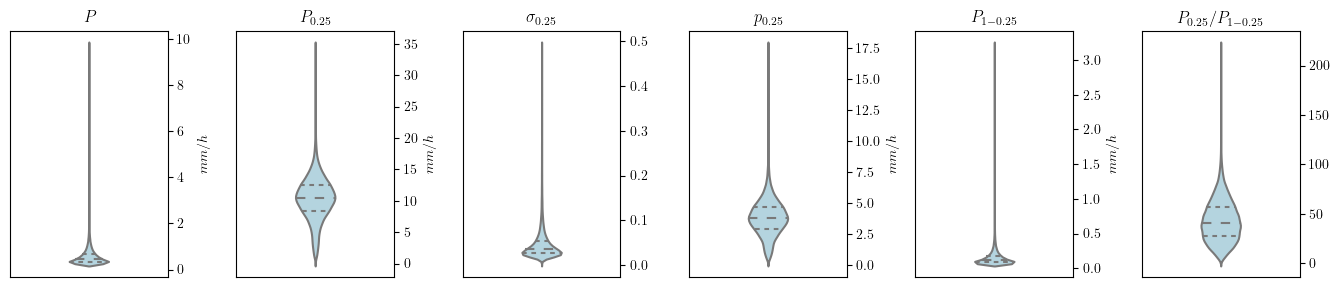

In [23]:
%matplotlib inline

jd.prec["strat_25_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_25_Prec * jd.prec.cond_alpha_25_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_25_Prec)
jd.prec["strat_conv_25_ratio_Prec"] = jd.prec.cond_alpha_25_Prec / jd.prec.strat_Prec


P = jd.prec.mean_unweighted_Prec.where(convective_mask).values.ravel()
p_25 = jd.prec.Treshold_cond_alpha_25_Prec.where(convective_mask).values.ravel()
P_25 = jd.prec.cond_alpha_25_Prec.where(convective_mask).values.ravel()
s_25 = jd.prec.Sigma_cond_alpha_25_Prec.where(convective_mask).values.ravel()
Ps_25 = jd.prec.strat_25_Prec.where(convective_mask).values.ravel()
Ratio_25 = jd.prec.strat_conv_25_ratio_Prec.where(convective_mask).values.ravel()

# data = {'$P$': [P, P_land], '$P_{0.25}$': [P_25, P_25_land], '$p_{0.25}$': [p_25, p_25_land], '$\sigma_{0.25}$': [s_25, s_25_land]}
data = {'$P$': [P], '$P_{0.25}$': [P_25], '$\sigma_{0.25}$': [s_25], '$p_{0.25}$': [p_25], '$P_{1-0.25}$' : [Ps_25], '$P_{0.25}/P_{1-0.25}$' : [Ratio_25]}

plt.rcParams['text.usetex'] = True

# Set up the plot
fig, axs = plt.subplots(1, 6, figsize=(13.5, 4))
y_labels = ["$mm/h$", "$mm/h$", "", "$mm/h$", "$mm/h$", ""]
# Violin Plot
for key, ax, y_label in zip(data.keys(), axs.flatten(), y_labels):
    # sns.violinplot(data=np.log1p(data[key]), inner="quartile", palette="pastel", ax = ax)
    sns.violinplot(data=data[key][0], inner="quart", color="lightblue", width=0.25, ax = ax, orient='v')
    # sns.violinplot(data=data[key][1], inner="quartile", palette="inferno", width=0.25, ax = ax, alpha = 0.25)

    ax.set_title(key)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.set_ylabel(y_label)
    ax.set_xticks([])
plt.tight_layout(rect=[0, 0, 1, 0.755])
plt.savefig("Precip_features.png")

In [24]:
from scipy.stats import spearmanr
# Assuming p_25 and s_25 are your data arrays
print(spearmanr(p_25[~np.isnan(p_25)], s_25[~np.isnan(s_25)]))
print(spearmanr(P_25[~np.isnan(P_25)], s_25[~np.isnan(s_25)]))
print(spearmanr(P_25[~np.isnan(P_25)], P[~np.isnan(P)]))

# triple corr coeff
np.corrcoef([P[~np.isnan(P)],  P_25[~np.isnan(P_25)],  s_25[~np.isnan(s_25)], p_25[~np.isnan(p_25)], Ps_25[~np.isnan(Ps_25)], Ratio_25[~np.isnan(Ratio_25)]])

SignificanceResult(statistic=-0.24797459383673442, pvalue=0.0)
SignificanceResult(statistic=-0.31766028997315493, pvalue=0.0)
SignificanceResult(statistic=0.3803552124247869, pvalue=0.0)


array([[ 1.        ,  0.33505541,  0.53752473,  0.40210569,  0.99388616,
        -0.55741913],
       [ 0.33505541,  1.        , -0.39898222,  0.97042808,  0.28749039,
         0.37648259],
       [ 0.53752473, -0.39898222,  1.        , -0.30008696,  0.57586101,
        -0.72978698],
       [ 0.40210569,  0.97042808, -0.30008696,  1.        ,  0.3569552 ,
         0.28871446],
       [ 0.99388616,  0.28749039,  0.57586101,  0.3569552 ,  1.        ,
        -0.54793534],
       [-0.55741913,  0.37648259, -0.72978698,  0.28871446, -0.54793534,
         1.        ]])

In [ ]:
# import seaborn as sns
# sns.jointplot(x=s_50, y=p_50, kind="scatter")
# sns.jointplot(x=s_50, y=P_50, kind="scatter")
# sns.jointplot(x=P, y=P_50, kind="scatter")
# sns.jointplot(x=Ps_50, y=P_50, kind="scatter")
# sns.jointplot(x=P, y=Ratio_50, kind="scatter")

# Let's analyse the new cond_prec var

###  it's computed as the average of precip which accounts for the upper 50% total rain flux of the global grid point. Sigma is the corresponding rain area average (over time and space), while sigma intra day is the average over space for each timestep. Threshold is the value of the precip that makes the difference between contributing to condPrec or not.

In [35]:
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "Sigma_cond_alpha_50_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True)
jd.make_mask()

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 4.31 seconds


In [37]:
rain_mask = jd.prec.mean_Prec == 0

/home/mcarenso/code/tempest/tempest/joint_distrib.py:919: RuntimeWarning: invalid value encountered in divide
  self.plot_data(bincount/bincount_reduced_prec, scale = 'linear',  cmap=plt.cm.magma_r, vbds = (0, 1), fig = fig, ax = ax, label = label)


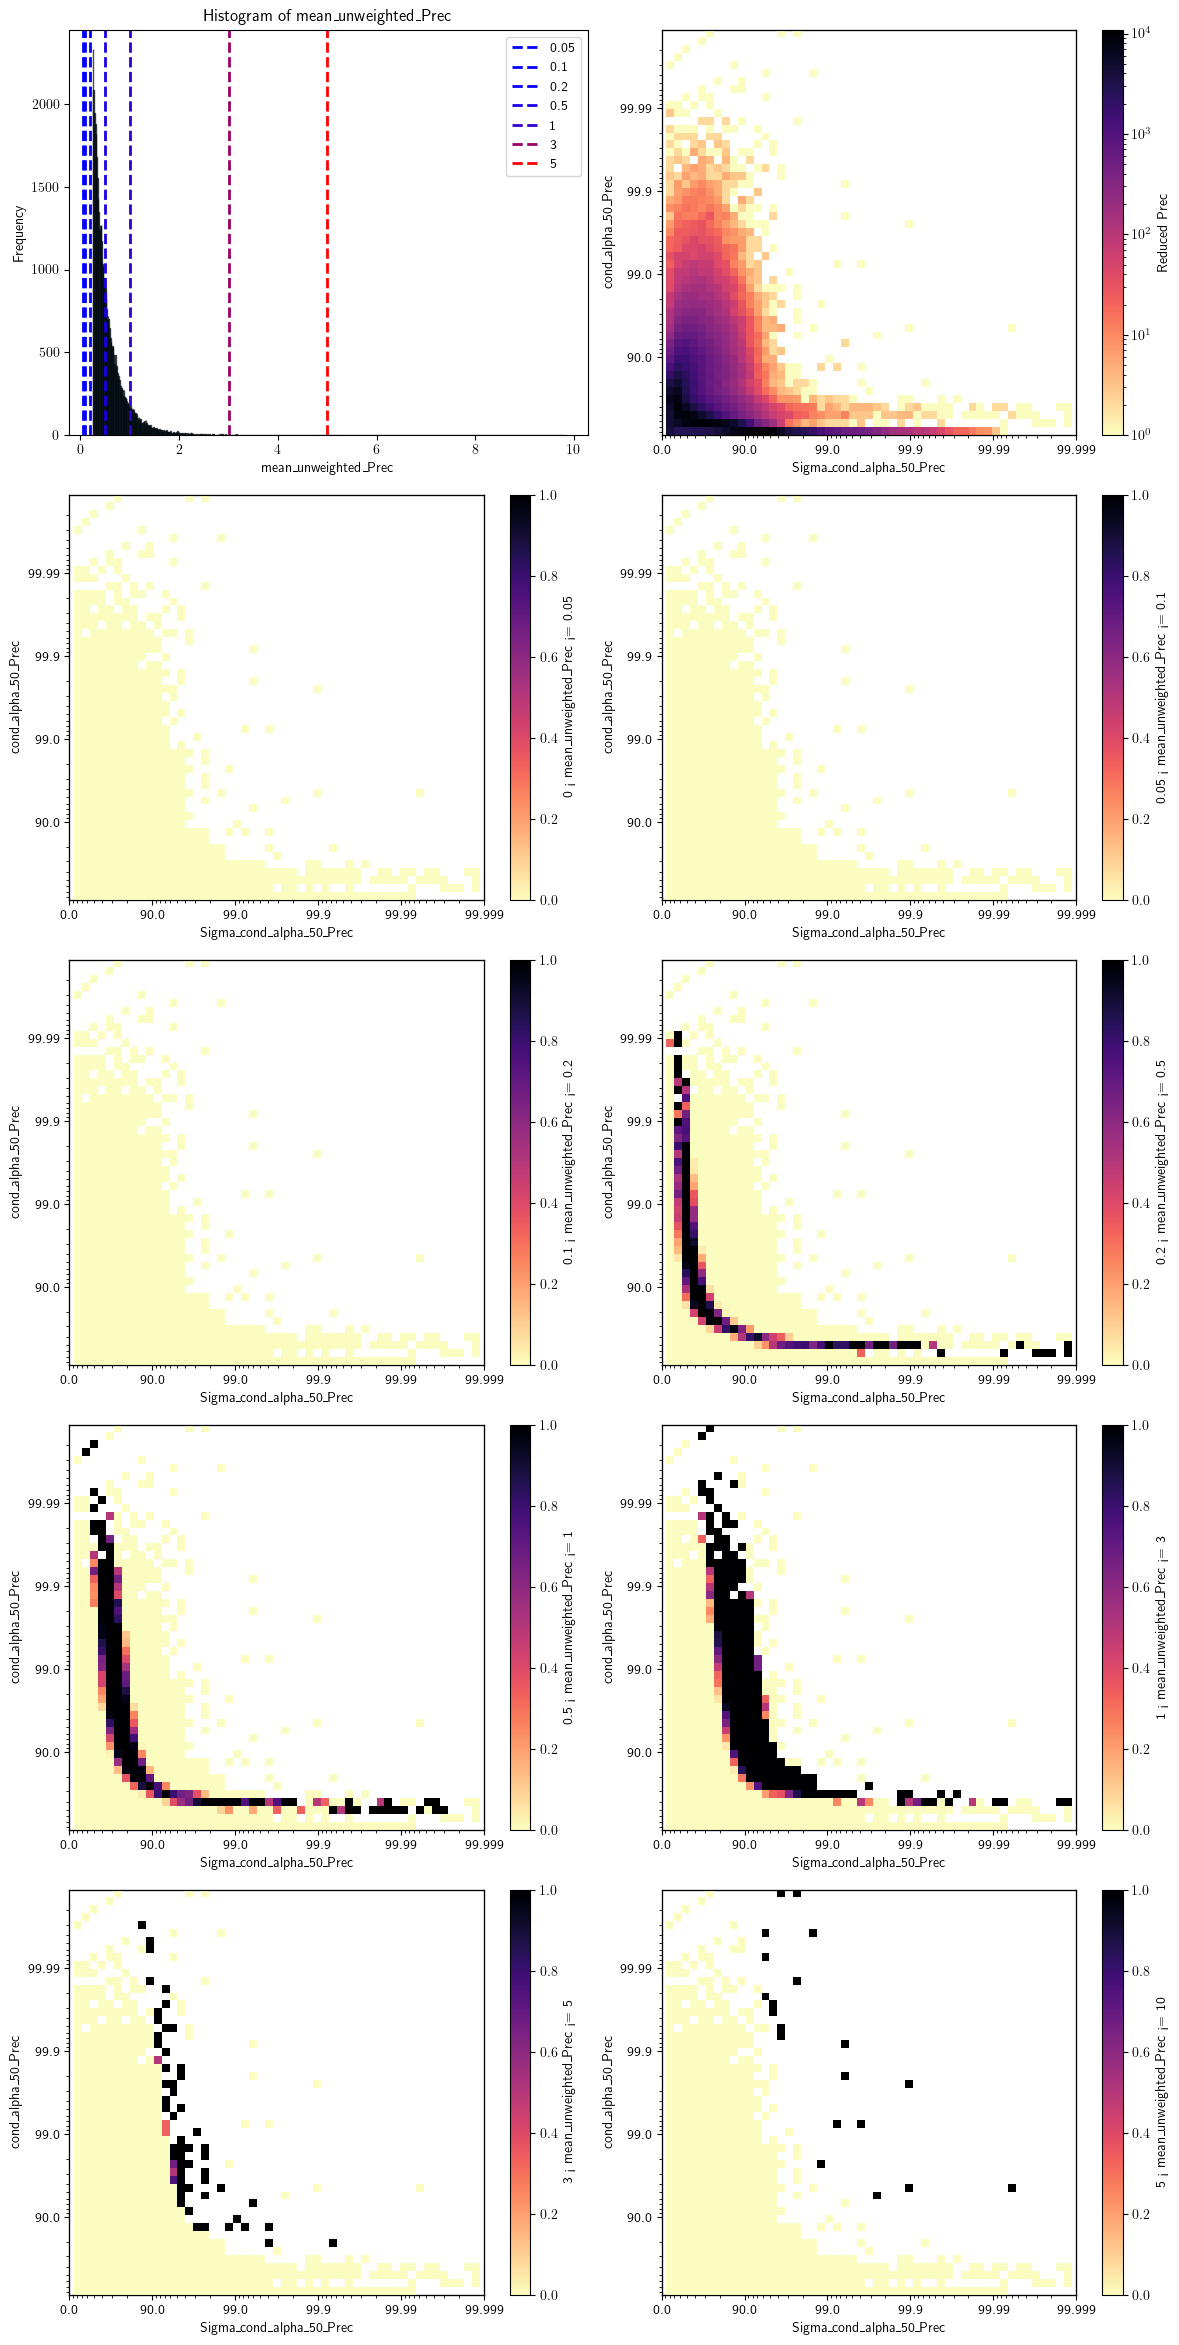

In [38]:
%matplotlib inline
cond_var = [0, 0.05, 0.1, 0.2, 0.5, 1, 3, 5, 10]
var_id = "Prec"
func = "mean_unweighted"
cond, tot = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = convective_mask, func=func)
plt.tight_layout()

In [39]:
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "Sigma_cond_alpha_50_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = False)

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 4.77 seconds


In [40]:
jd.prec["strat_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_50_Prec * jd.prec.cond_alpha_50_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_50_Prec)

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.26 seconds


TypeError: 'bool' object is not subscriptable

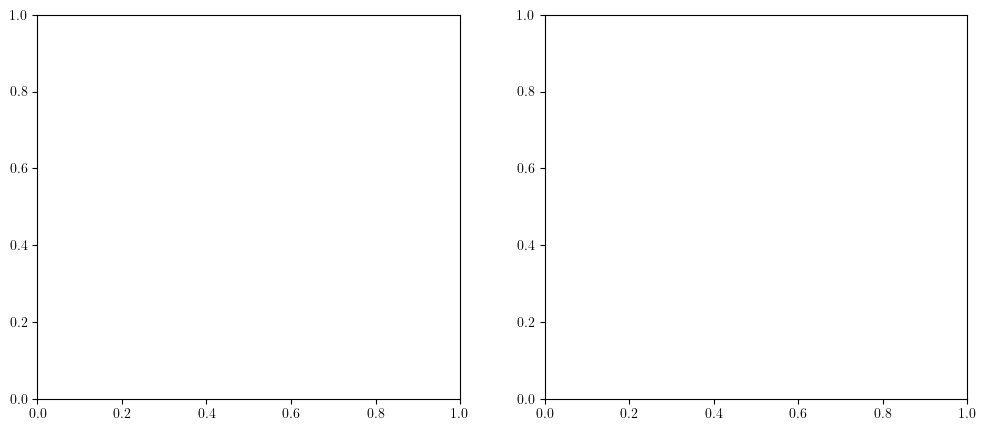

In [41]:
##1
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = False)

## Build stratiform Prec
jd.prec["strat_Prec"] = (jd.prec.mean_unweighted_Prec - jd.prec.Sigma_cond_alpha_50_Prec * jd.prec.cond_alpha_50_Prec ) / ( 1 - jd.prec.Sigma_cond_alpha_50_Prec)
jd.prec["strat_conv_ratio_Prec"] = jd.prec.cond_alpha_50_Prec / jd.prec.strat_Prec
fig, axs = plt.subplots(1, 2, figsize = (2*6, 4.99))
cmap = sns.color_palette("icefire", as_cmap=True)
ax = axs[1]
ax, cb = jd.plot_var_id_func_over_jdist('Prec', func = 'cond_alpha_50', mask = True, cmap = cmap, fig = fig, ax = ax)
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$P$ ranks")
ax.set_title("$P_{0.5}$ averaged in joint bins of $P$, $P_{0.5}$")
cb.set_label("$P_{0.5} (mm/h)$")

ax = axs[0]
ax, cb = jd.plot_var_id_func_over_jdist('Prec', func = 'strat', mask = True, cmap = cmap, fig = fig, ax = ax)
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$P$ ranks")
ax.set_title("$strat prec$ averaged in joint bins of $P$, $P_{0.5}$")
cb.set_label("$strat prec (mm/h)$")

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 4.33 seconds


TypeError: 'bool' object is not subscriptable

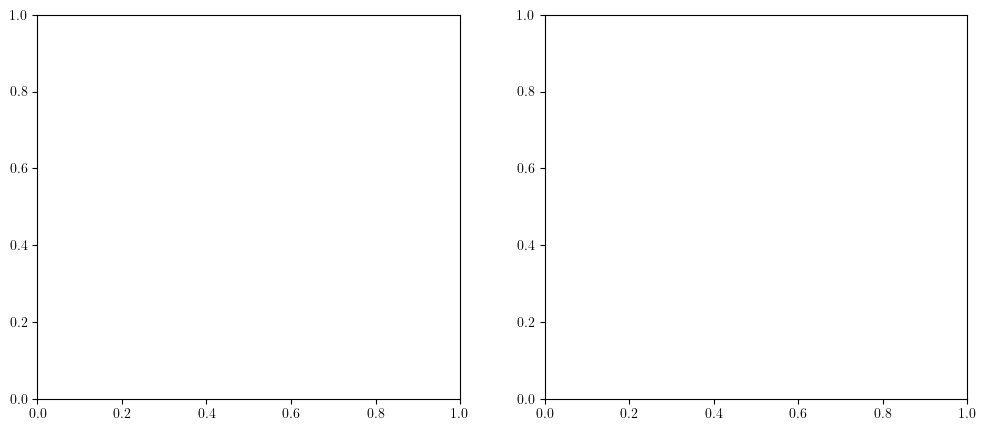

In [42]:
%matplotlib inline

## 1
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "Sigma_cond_alpha_50_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = True)
fig, axs = plt.subplots(1, 2, figsize = (2*6, 4.99))
cmap = sns.color_palette("icefire", as_cmap=True)
ax = axs[1]
ax, cb = jd.plot_var_id_func_over_jdist('Prec', func = 'mean_unweighted', mask = True, cmap = cmap, fig = fig, ax = ax)
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$\sigma_{0.5}$ ranks")
ax.set_title("$\P$ averaged in joint bins of $\sigma_{0.5}$, $P_{0.5}$")
cb.set_label("$P (mm/h)$")

ax = axs[0]
jd.plot_data(jd.bincount, scale = 'log', label = "N° of $X$ elements", cmap=plt.cm.magma_r , fig = fig, ax = ax)
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$\sigma_{0.5}$ ranks")
ax.set_title("Bincount of $X$ elements in joint distribution of $\sigma_{0.5}$, $P_{0.5}$")

plt.tight_layout()

##1
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = True)
fig, axs = plt.subplots(1, 2, figsize = (2*6, 4.99))
cmap = sns.color_palette("icefire", as_cmap=True)
ax = axs[1]
ax, cb = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_50', mask = True, cmap = cmap, fig = fig, ax = ax)
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$P$ ranks")
ax.set_title("$\sigma_{0.5}$ averaged in joint bins of $P$, $P_{0.5}$")
cb.set_label("$\sigma_{0.5} (mm/h)$")

ax = axs[0]
jd.plot_data(jd.bincount, scale = 'log', label = "N° of $X$ elements", cmap=plt.cm.magma_r , fig = fig, ax = ax)
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$P$ ranks")
ax.set_title("Bincount of $X$ elements in joint distribution of $P$, $P_{0.5}$")

plt.tight_layout()

In [43]:
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = True)

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 3.88 seconds


TypeError: 'NoneType' object is not subscriptable

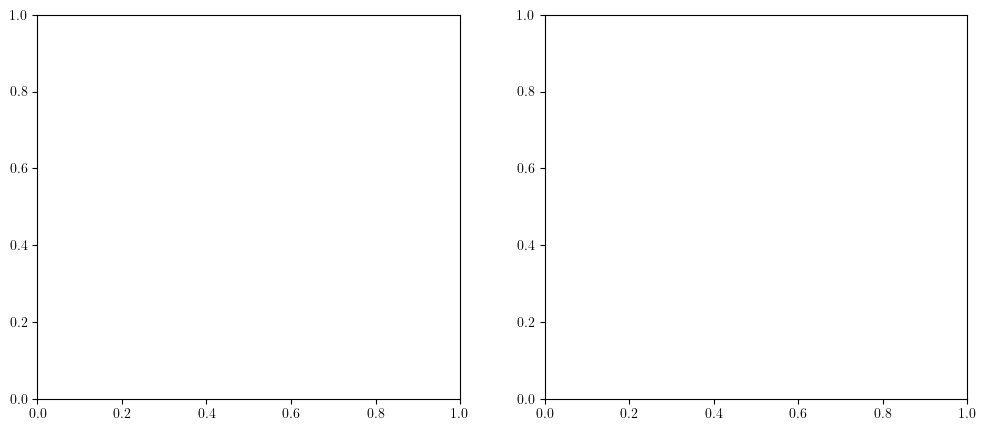

In [47]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize = (2*6, 4.99))
cmap = sns.color_palette("icefire", as_cmap=True)
ax = axs[1]
ax, cb = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_50', mask = None,  cmap = cmap, fig = fig, ax = ax) #mask = ocean,
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$P$ ranks")
ax.set_title("$P$ averaged in joint bins")
cb.set_label("$P (mm/h)$")

ax = axs[0]
jd.plot_data(jd.bincount, scale = 'log', label = "N° of $X$ elements", cmap=plt.cm.magma_r , fig = fig, ax = ax)
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$P$ ranks")
ax.set_title("Bincount of $X$ elements in joint distribution of $P_{0.5}$, $\sigma_{0.5}$")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4.78))
jd.plot_data(jd.bincount, scale = 'log', label = "N° of $X$ elements", cmap=plt.cm.magma_r , fig = fig, ax = ax)
ax.set_ylabel("$P_{0.5}$ ranks")
ax.set_xlabel("$\sigma_{0.5}$ ranks")
ax.set_title("Bincount of $X$ elements in joint distribution of $P_{0.5}$, $\sigma_{0.5}$")

In [ ]:
ax = jd.plot_var_id_func_over_jdist('Prec', func = 'Treshold_cond_alpha_50', mask = True, cmap = 'mako_r')

In [48]:
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "cond_alpha_50_Prec", var_id_2 = "Treshold_cond_alpha_50_Prec", nd=4, overwrite = True)
# jd_mm = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_Prec", var_id_2 = "max_Prec", nd=5, overwrite = True)

Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 4.11 seconds


In [55]:
ocean.shape

(60, 360, 1)

In [ ]:
jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_50', mask = ocean, cmap = 'tab20')

In [ ]:
simple_hist(jd.prec.Sigma_cond_alpha_50_Prec.values.flatten(), "mean_Sigma_cond_alpha_50", mean_and_std = None, bars= None)

In [ ]:
%matplotlib inline

cond_var_T2m_sat = list(np.arange(0, 30, 3))
var_id = "Prec"
func = "Treshold_cond_alpha_50"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var_T2m_sat, func=func)
plt.tight_layout()

In [ ]:
jd.plot_var_id_func_over_jdist('Prec', func = 'Treshold_cond_alpha_50', mask = ocean, cmap = 'tab20')

In [ ]:
treshold = np.sort(jd.prec.Treshold_cond_alpha_50_Prec.values.flatten())
simple_hist(treshold[200000:], "mean_Sigma_cond_alpha_50", mean_and_std = None, bars= None)

In [ ]:
simple_hist(treshold[:], "mean_Sigma_cond_alpha_50", mean_and_std = None, bars= None)

## OM850_cond_Prec with 1timestep of lag

In [ ]:
%matplotlib inline

cond_var = [-1, -0.6, -0.3, -0.2, -0.1, -0.05, 0]
var_id = "neg_OM850_cond_Prec_lag_1"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = ocean, func=func)

In [ ]:
jd.plot_var_id_func_over_jdist('OM850_cond_Prec_lag_1', func = 'mean', mask = ocean)

In [ ]:
%matplotlib inline

cond_var = [-1, -0.2, -0.1, -0.05,  0, 0.05, 0.1, 0.3]
var_id = "OM850_cond_Prec"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = ocean, func=func)

# QV_sat_2d

## Ocean

In [ ]:
%matplotlib inline

cond_var_T2m_sat = [0, 0.018, 0.020, 0.021, 0.023, 0.0245, +np.inf]
var_id = "QV_sat_2d"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var_T2m_sat, mask = ocean, func=func)

In [ ]:
jd.plot_var_id_func_over_jdist('QV_sat_2d', func = 'mean', mask = ocean)

### Land

In [ ]:
%matplotlib inline

cond_var_T2m_sat = [0, 0.015, 0.0175, 0.021, 0.0245, 0.028, 0.035, +np.inf]
var_id = "QV_sat_2d"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var_T2m_sat, mask = land, func=func)

# SST #T2MM

In [ ]:
%matplotlib inline

cond_var_T2m_sat = [0, 0.018, 0.021, 0.0245, +np.inf]
var_id = "T2mm"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var_T2m_sat, mask = ocean, func=func)

# W500

## Positive only, Ocean

In [ ]:
%matplotlib inline

cond_var = [0, 0.05, 0.1, 0.2, 0.3, 0.4, +np.inf]
var_id = "W500_pos"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = ocean, func=func)

## Positive Only, Land

In [ ]:
%matplotlib inline

cond_var = [0, 0.05, 0.1, 0.2, 0.3, 0.4, +np.inf]
var_id = "W500_pos"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = land, func=func)

### Ocean

In [ ]:
%matplotlib inline

cond_var = [-np.inf, -0.03, 0, 0.05, +np.inf]
var_id = "W500"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = ocean, func=func)

### Land

In [ ]:
%matplotlib inline

cond_var = [-np.inf, -0.03, 0, 0.05, +np.inf]
var_id = "W500"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = land, func=func)

# OM500

In [ ]:
%matplotlib inline

cond_var = [-np.inf, -0.3, -0.2, -0.15, 0, 0.15, +np.inf]
var_id = "OM500"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, func=func)

# PW

### Ocean

In [ ]:
%matplotlib inline

cond_var = [0, 35, 45, 54, 60, 70, 80]
var_id = "PW"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = ocean, func=func)

### Land

In [ ]:
%matplotlib inline

cond_var = [0, 15, 25, 35, 48, 54, 65, 80]
var_id = "PW"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, mask = land, func=func)

# RH 850

In [ ]:
%matplotlib inline

cond_var = [0, 0.22, 0.38, 0.65, +np.inf]
var_id = "RH850"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, func=func)

# RH500

In [ ]:
%matplotlib inline

cond_var = [0, 0.15, 0.3, 0.45, 0.5, 0.6, 0.7, 0.8, +np.inf]
var_id = "RH500"
func = "mean"
bincounts = jd.process_plot_var_cond_reducing_prec(var_id, cond_var, func=func)

### Map

In [ ]:
import cartopy.crs as ccrs
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)
jd.make_mask()

mask_all = jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'

for mask,mask_name,mask_label in zip(mask_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask)
    ax = jd.make_map(mask_yxt)
    lon_min, lon_max = 215, 280 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='red', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Eastern Pacific ITCZ")
    lon_min, lon_max = 130, 185 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 20#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='blue', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
    ax.legend()
    
    ax.set_title(mask_name)

    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.pdf'%(mask_label)),bbox_inches='tight')
    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

In [ ]:
data, noise, count = jd.get_mcs_bin_fraction(0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.76))
jd.plot_data(data, noise, branch=False, fig= fig, ax = ax, vbds = (0, 1))

In [ ]:
jd_mm = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_Prec", var_id_2 = "max_Prec", nd=5, overwrite = True)

In [ ]:
data, noise, count = jd_mm.get_mcs_bin_fraction(0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.76))
jd_mm.plot_data(data, noise, branch=False, fig= fig, ax = ax, vbds = (0, 1))

## MCS var

In [ ]:
da_var = jd.grid.get_var_id_ds("MCS_label").sortby("days")['Rel_surface']

In [ ]:
%matplotlib inline
da_var.where(ocean)
var = da_var.values.flatten()
var_cond_list = [0, 0.01, 0.1, 1]
simple_hist(var, "Rel_Surface", bars= var_cond_list) #label = f"Simple hist of {var_id}"

In [ ]:
%matplotlib inline
var = "vavg"
var_cond_list = [0, 2, 3, 4, 5, 6, 8, 10, 15, 20, np.inf]
cond, tot = jd.process_plot_var_cond_reducing_prec(var_id = var, var_cond_list = var_cond_list, func = "MCS")

In [ ]:
tot2 = np.full(tot.shape, 0, dtype = float)
for c in cond:
    tot2+=c
jd.plot_data(tot2/tot)

In [ ]:
var = "Rel_surface"
var_cond_list = [0, 0.03, 0.05, 0.1, 0.2]
cond, tot = jd.process_plot_var_cond_reducing_prec(var_id = var, var_cond_list = var_cond_list, mask = ocean, func = "MCS")

In [ ]:
tot2 = np.full(tot.shape, 0, dtype = float)
for c in cond:
    tot2+=c
plt.imshow(tot2/tot, origin = 'lower')
plt.colorbar()

In [ ]:
var = "duration"
var_cond_list = [0, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
cond, tot = jd.process_plot_var_cond_reducing_prec(var_id = var, var_cond_list = var_cond_list, mask = ocean, func = "MCS")

In [ ]:
tot2 = np.full(tot.shape, 0, dtype = float)
for c in cond:
    tot2+=c
plt.imshow(tot2/tot, origin = 'lower')
plt.colorbar()

In [ ]:
var = "dist"
var_cond_list = [0, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000, np.inf]
cond, tot = jd.process_plot_var_cond_reducing_prec(var_id = var, var_cond_list = var_cond_list, mask = ocean, func = "MCS")

In [ ]:
var = "surfmaxkm2_172Wm2"
var_cond_list = [0, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 300000, np.inf]
cond, tot = jd.process_plot_var_cond_reducing_prec(var_id = var, var_cond_list = var_cond_list, mask = ocean, func = "MCS")

In [13]:
var = "stationary_time"
var_cond_list = [0, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 300000, np.inf]
cond, tot = jd.process_plot_var_cond_reducing_prec(var_id = var, var_cond_list = var_cond_list, mask = ocean, func = "MCS")

KeyError: 'stationary_time'

## here we made stationary time

In [ ]:
ds_mcs = gr.get_var_id_ds("MCS_label")
grid_surf = gr.grid_surface
caracteric_length = np.sqrt(grid_surf)*1000*np.sqrt(2)
caracteristic_time = caracteric_length[:,:,np.newaxis]/ds_mcs.vavg
duration_seconds = ds_mcs.duration*7200
import xarray as xr
stationary_time = xr.where(duration_seconds>caracteristic_time, caracteristic_time, duration_seconds)
ds_mcs["stationary_time"]=stationary_time
file_mcs = gr.get_var_ds_file("MCS_label")
import os 
os.remove(file_mcs)
ds_mcs.to_netcdf(file_mcs)

## duration bug

In [ ]:
d = ds_mcs.duration.values.ravel()
simple_hist(d, "duration")

# Old Cond Precip (where we choose the cutoff depending on precip values. Either at a certain percentile of the indra day precipitation (95%, 99%, 99.9%) or an arbitrary value (wet day 1mm/h, convective at 32mm/h which corresponds to 99th percentile of native distrib))

# Load Joint Distribs

In [ ]:
jd_mean_heavy = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "heavy_Prec", overwrite = True)
jd_mean_supra = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "supra_Prec", overwrite = True)
jd_mean_ultra = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "ultra_Prec", overwrite = True)
jd_mean_max = joint_distrib.JointDistribution(gr, st, nd=5, var_id_1 = "mean_Prec", var_id_2 = "max_Prec", overwrite =True, regionalize=False)
jd_mean_convective = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "convective_Prec", overwrite = True)
jds_mean = [jd_mean_heavy, jd_mean_supra, jd_mean_ultra, jd_mean_max, jd_mean_convective]

jd_wet_heavy = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "wet_Prec", var_id_2 = "heavy_Prec", overwrite = True)
jd_wet_supra = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "wet_Prec", var_id_2 = "supra_Prec", overwrite = True)
jd_wet_ultra = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "wet_Prec", var_id_2 = "ultra_Prec", overwrite = True)
jd_wet_max = joint_distrib.JointDistribution(gr, st, nd=5, var_id_1 = "wet_Prec", var_id_2 = "max_Prec", overwrite =True, regionalize=False)
jd_wet_convective = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "wet_Prec", var_id_2 = "convective_Prec", overwrite = True)
jds_wet = [jd_wet_heavy, jd_wet_supra, jd_wet_ultra, jd_wet_max, jd_wet_convective]

jds = jds_mean + jds_wet

# oh la chelou
jd_mean_wet = joint_distrib.JointDistribution(gr, st, nd = 5, var_id_1 = "mean_Prec", var_id_2 = "wet_Prec", overwrite = True)


# Show Bincounts

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(nrows = 5, ncols =2, figsize = (8, 16))
for jd_mean, ax_mean, jd_wet, ax_wet in zip(jds_mean, axs[:,0], jds_wet, axs[:,1]):
    # Left side
    jd_mean.plot_data(jd_mean.bincount, scale = 'log', cmap=plt.cm.magma_r , fig =fig, ax = ax_mean, vbds = (1, 1e4))
    # Right side
    jd_wet.plot_data(jd_wet.bincount, scale = 'log', cmap =plt.cm.magma_r, fig=fig, ax=ax_wet, vbds=(1, 1e4))
    
plt.tight_layout()

In [ ]:
%matplotlib inline
jd_mean_wet.plot_data(jd_mean_wet.bincount, scale = 'log', cmap=plt.cm.magma_r, vbds = (1, 1e4))

# Show Normalized Density

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(nrows = 5, ncols =2, figsize = (8, 16))
for jd_mean, ax_mean, jd_wet, ax_wet in zip(jds_mean, axs[:,0], jds_wet, axs[:,1]):
    # Left side
    jd_mean.plot_data(jd_mean.norm_density, scale = 'log', cmap=plt.cm.BrBG , fig =fig, ax = ax_mean, vbds = (1e-3,1e3))
    # Right side
    jd_wet.plot_data(jd_wet.norm_density, scale = 'log', cmap=plt.cm.BrBG, fig=fig, ax=ax_wet, vbds=(1e-3,1e3))
    
plt.tight_layout()

In [ ]:
%matplotlib inline
jd_mean_wet.plot_data(jd_mean_wet.norm_density, scale = 'log', cmap=plt.cm.BrBG, vbds=(1e-3,1e3))
plt.show()

# Mutual Information

In [ ]:
import math

def mutual_information(self, treshold=10):
    mi_pos = 0
    mi_neg = 0
    l1, l2 = len(self.bins1)-1, len(self.bins2)-1
    for i in range(treshold, l1):
        for j in range(treshold, l2):
            if self.norm_density[i,j] != 0 : 
                mi_ij = self.density[i,j]*math.log10(self.norm_density[i,j])
                if mi_ij >0:
                    mi_pos+=mi_ij
                else:
                    mi_neg+=mi_ij
            else : 
                pass
                
    return mi_pos+mi_neg, mi_pos, mi_neg

### For mean_Precip with treshold 10

In [ ]:
mean_mi = []
mean_mi_pos = []
mean_mi_neg = []
for jd_mean in jds_mean:
    mi = mutual_information(jd_mean)
    mean_mi.append(mi[0])
    mean_mi_pos.append(mi[1])
    mean_mi_neg.append(-mi[2])
plt.plot(mean_mi)
plt.plot(mean_mi_pos)
plt.plot(mean_mi_neg)
plt.title("Mean precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins")

### same but no treshold

In [ ]:
mean_mi = []
mean_mi_pos = []
mean_mi_neg = []
treshold = 0
for jd_mean in jds_mean:
    mi = mutual_information(jd_mean, treshold)
    mean_mi.append(mi[0])
    mean_mi_pos.append(mi[1])
    mean_mi_neg.append(-mi[2])
    
plt.plot(mean_mi)
plt.plot(mean_mi_pos)
plt.plot(mean_mi_neg)
plt.title("Mean precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins")

### For wet Precip with treshold at 10th bin

In [ ]:
mean_mi = []
mean_mi_pos = []
mean_mi_neg = []
treshold = 10
for jd in jds_wet:
    jd.compute_joint_density(jd.sample1, jd.sample2)
    mi = mutual_information(jd, treshold)
    mean_mi.append(mi[0])
    mean_mi_pos.append(mi[1])
    mean_mi_neg.append(-mi[2])
    
plt.plot(mean_mi)
plt.plot(mean_mi_pos)
plt.plot(mean_mi_neg)
plt.title("Wet precip vs heavy, supra, ultra, max, convective(?), with treshold at 10th bins")

## For wet precip no treshold

In [ ]:
mean_mi = []
mean_mi_pos = []
mean_mi_neg = []
treshold = 0
for jd in jds_wet:
    # jd.compute_joint_density(jd.sample1, jd.sample2)
    mi = mutual_information(jd, treshold)
    mean_mi.append(mi[0])
    mean_mi_pos.append(mi[1])
    mean_mi_neg.append(-mi[2])
    
plt.plot(mean_mi)
plt.plot(mean_mi_pos)
plt.plot(mean_mi_neg)
plt.title("Wet precip vs heavy, supra, ultra, max, convective(?), with no bins treshold")

# Plot alphas

### Process weird values (outrageously negative or way too high. Seems to only happend for relatives treshold, either due to np.percentile behvaior, or subsequent indexing)

In [ ]:
prec = 'just_here_to_shut_UX'

#

In [ ]:
alpha_names = ["Alpha_1mm_per_h", "Alpha_95", "Alpha_99", "Alpha_99_99", "Alpha_99_99_native"]
jds_alpha = [jd_mean_wet, jd_mean_heavy, jd_mean_supra, jd_mean_ultra, jd_mean_convective]
alphas_on_density = []
for alpha, jd in zip(alpha_names, jds_alpha):
    if alpha=="Alpha_95" : 
        mask = (prec[alpha].values < 0) | (prec[alpha].values > 50)
        prec[alpha].values[mask] = np.nan
        clean_alpha = prec[alpha].values
    elif alpha == "Alpha_99":
        mask = (prec[alpha].values < 0) | (prec[alpha].values > 30)
        prec[alpha].values[mask] = np.nan
        clean_alpha = prec[alpha].values
    elif alpha == "Alpha_99_99":
        mask = (prec[alpha].values < 0) | (prec[alpha].values > 10)
        prec[alpha].values[mask] = np.nan
        clean_alpha = prec[alpha].values
    else : 
        clean_alpha =  prec[alpha].values

    alphas_on_density.append(jd.compute_conditional_data_over_density(jd.sample1, jd.sample2, clean_alpha))

### Alpha values on their according joint distrib vs Mean Precip + thier histogram for understanding bounds choice

In [ ]:
fig, axs = plt.subplots(nrows = 5, ncols=2, figsize=(12,24))
alphas_vbds = [(0, 1.5), (0, 1), (0,1), (0, 0.3), (None, None)]
for jd, alpha, ax, vbds, ax_hist, name in zip(jds_alpha, alphas_on_density, axs[:,0].flatten(), alphas_vbds, axs[:,1].flatten(),alpha_names):
    jd.plot_data(alpha, fig = fig, ax = ax, cmap = plt.cm.viridis, vbds=vbds)
    simple_hist(alpha, name, fig = fig, ax = ax_hist, mean_and_std=False)

#### Native (regridded) alpha hist for processing purposes

In [ ]:
alpha_95 = np.sort(prec["Alpha_99"].values.flatten())
simple_hist(alpha_95, "Alpha_99", bounds = (0, 100), mean_and_std=False)